# Import libraries and files

In [1]:
import numpy as np
import nibabel.processing as nibp
import os
import nibabel as nib
import math
import random
import matplotlib.pyplot as plt

In [2]:
def create_noise():
    a_n = random.uniform(5,10)
    b_n = random.uniform(1,2)
    c_n = random.uniform(200,300)
    y_n = np.array([a_n*np.sin(i*b_n)+c_n+0.01*random.randint(-100,100) for i in range(156)])
    return y_n

In [3]:
def create_signal():
    a_n = random.uniform(5,10)
    b_n = random.uniform(1,3)
    c_n = random.uniform(200,300)
    y_n = np.array([a_n*np.sin(i*b_n)+c_n+0.01*random.randint(-100,100) for i in range(156)])
    a_s = random.uniform(5,10)
    b_s = random.uniform(8,10)
    c_s = random.uniform(200,300)
    y_s = np.array([a_s*np.sin(i*b_s)+c_s+0.01*random.randint(-100,100) for i in range(156)])
    return [y_s,y_n + y_s]

In [4]:
num_noise = 10000
noise_list = np.zeros([num_noise, 156])
for i in range(num_noise):
        noise_list[i] = create_noise()

In [5]:
num_signal = 10000
ground_truth = np.zeros([num_signal, 156])
signal_list = np.zeros([num_signal, 156])
for i in range(num_signal):
    ground_truth[i] = create_signal()[0]
    signal_list[i] = create_signal()[1]

In [6]:
print(signal_list.shape)
print(noise_list.shape)
print(ground_truth.shape)

(10000, 156)
(10000, 156)
(10000, 156)


Text(0.5, 1.0, 'noise')

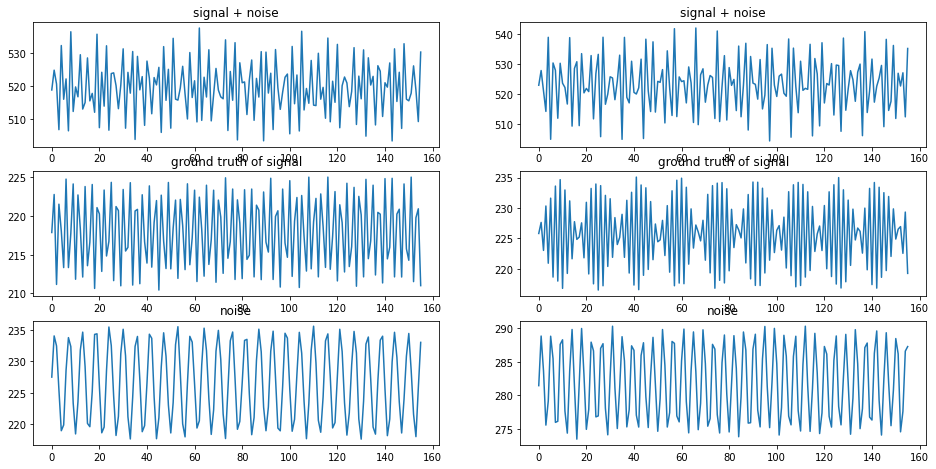

In [7]:
x = [i for i in range(156)]
plt.figure(figsize = (16,16))
plt.subplot(6,2,1)
plt.plot(x,signal_list[25],'-')
plt.title('signal + noise')
plt.subplot(6,2,2)
plt.plot(x,signal_list[19],'-')
plt.title('signal + noise')
plt.subplot(6,2,3)
plt.plot(x,ground_truth[25],'-')
plt.title('ground truth of signal')
plt.subplot(6,2,4)
plt.plot(x,ground_truth[19],'-')
plt.title('ground truth of signal')
plt.subplot(6,2,5)
plt.plot(x,noise_list[47],'-')
plt.title('noise')
plt.subplot(6,2,6)
plt.plot(x,noise_list[900],'-')
plt.title('noise')

In [8]:
max_signal = np.max(signal_list)
max_noise = np.max(noise_list)

# DataLoader

In [10]:
# data split
from sklearn.model_selection import train_test_split
training_gm, remaining_gm = train_test_split(signal_list, test_size=0.4, random_state=42)
validating_gm, testing_gm = train_test_split(remaining_gm, test_size=0.5, random_state=42)
training_cf, remaining_cf = train_test_split(noise_list, test_size=0.4, random_state=42)
validating_cf, testing_cf = train_test_split(remaining_cf, test_size=0.5, random_state=42)
training_gt, remaining_gt= train_test_split(ground_truth, test_size=0.4, random_state=42)
validating_gt, testing_gt = train_test_split(remaining_gt, test_size=0.5, random_state=42)


In [11]:
# dataloading 
import torch
train_gm = torch.utils.data.DataLoader(training_gm, batch_size=64,
                                             shuffle=True, num_workers=1)
validation_gm = torch.utils.data.DataLoader(validating_gm, batch_size=64,
                                             shuffle=True, num_workers=1)
test_gm = torch.utils.data.DataLoader(testing_gm, batch_size=64,
                                             shuffle=True, num_workers=1)

train_cf = torch.utils.data.DataLoader(training_cf, batch_size=64,
                                             shuffle=True, num_workers=1)
validation_cf = torch.utils.data.DataLoader(validating_cf, batch_size=64,
                                             shuffle=True, num_workers=1)
test_cf = torch.utils.data.DataLoader(testing_cf, batch_size=64,
                                             shuffle=True, num_workers=1)
test_gt = torch.utils.data.DataLoader(testing_gt, batch_size=64,
                                             shuffle=True, num_workers=1)

# cVAE model

In [12]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

In [13]:
import torch
from torch import nn
from torch.nn import functional as F

class cVAE(nn.Module):


    def __init__(self,in_channels: int,latent_dim: int,hidden_dims: List = None) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 128]

        # Build Encoder
        for h_dim in hidden_dims:
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*10, latent_dim)

        modules_s = []
        in_channels = self.in_channels
        for h_dim in hidden_dims:
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*10, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * 10)

        hidden_dims.reverse()


        for i in range(len(hidden_dims) - 1):
            if i//2==0:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                        nn.BatchNorm1d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose1d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=0),
                        nn.BatchNorm1d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               out_channels = 1,
                                               kernel_size=3,
                                               stride=2,
                                               padding=2,
                                               output_padding=1))
                            # nn.BatchNorm1d(hidden_dims[-1]),
                            # nn.LeakyReLU(),
                            # nn.Conv1d(hidden_dims[-1], out_channels= 1,
                            #           kernel_size= 3, padding= 0),
                            # nn.Tanh())
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,128,10)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]:
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_s, bg_log_var_s = self.encode_s(input)
        bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
        zeros = torch.zeros_like(bg_s)
        output = self.decode(torch.cat((zeros, bg_s),1))
        return  [output, input, bg_mu_s, bg_log_var_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        fg_mu_z, fg_log_var_z = self.encode_z(input)
        tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
        zeros = torch.zeros_like(tg_z)
        output = self.decode(torch.cat((tg_z, zeros),1))
        return  [output, input, fg_mu_z, fg_log_var_z]

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        beta = 0.001
        gamma = 1

        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_s = args[10]
        bg_log_var_s = args[11]
        

        #kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons_tg, input_tg)
        recons_loss += F.mse_loss(recons_bg, input_bg)
        # recons_loss *= input_shape[0]*input_shape[1]

        # z1 = tg_z[:int(batch_size/2),:]
        # z2 = tg_z[int(batch_size/2):,:]
        # s1 = tg_s[:int(batch_size/2),:]
        # s2 = tg_s[int(batch_size/2):,:]
        # q_bar = torch.cat(torch.cat((s1,z2),1),torch.cat((s2,z1),1),0)
        # q = torch.cat(torch.cat((s1,z1),1),torch.cat((s2,z1),1),0)
        # q_bar_score = nn.Sigmoid(q_bar)
        # q_score = nn.Sigmoid(q)
        # tc_loss = torch.log(q_score/(1-q_score))
        # discriminator_loss = - torch.log(q_score) - torch.log(1-q_bar_score)

        kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
        kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
        kld_loss += 1 + bg_log_var_s - bg_mu_s ** 2 - bg_log_var_s.exp()
        kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

        loss = torch.mean(recons_loss + beta*kld_loss)
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]



In [14]:
model = cVAE(1,1280)

In [15]:
model

cVAE(
  (encoder_z): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu_z): Linear(in_features=128

In [16]:
# optimizer
import torch.optim as optim
optimizer = optim.SGD(model.parameters(),lr=0.001)
#optimizer = optim.RMSprop(model.parameters())
# rho? = 0.9

In [17]:
print(len(train_gm))

94


In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch_size = 64
epoch_num = 10
running_loss_L = []
running_recons_L = []
running_KLD_L = []
val_loss_L = []
val_recons_L = []
val_KLD_L = []

for epoch in range(epoch_num):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, epoch_num-1))
    print('-' * 10)

    running_loss = 0.0
    running_reconstruction_loss = 0.0
    running_KLD = 0.0
    running_corrects = 0
    val_loss = 0.0
    val_reconstruction_loss = 0.0
    val_KLD = 0.0

    # Iterate over data.
    dataloader_iter_gm = iter(train_gm)
    dataloader_iter_cf = iter(train_cf)
    for i in range(len(train_gm)):
        try:
            inputs_gm = next(dataloader_iter_gm)
        except StopIteration:
            dataloader_iter_gm = iter(train_gm)
            inputs_gm = next(dataloader_iter_gm)

        try:
            inputs_cf = next(dataloader_iter_cf)
        except StopIteration:
            dataloader_iter_cf = iter(train_cf)
            inputs_cf = next(dataloader_iter_cf)

        inputs_gm = inputs_gm.unsqueeze(1).float() /max_signal
        inputs_gm = inputs_gm.to(device)
        inputs_cf = inputs_cf.unsqueeze(1).float() /max_noise
        inputs_cf = inputs_cf.to(device)
        #print(inputs_gm)
        #print(inputs_cf)

        # zero the parameter gradients
        optimizer.zero_grad()

        # encoder + decoder
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
        #print(tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,bg_mu_s, bg_log_var_s)
        #print(outputs_gm.size())
        #print(outputs_cf.size())
        outputs = torch.concat((outputs_gm,outputs_cf),1)
        loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)

        #print(loss)

        # backward + optimize
        loss['loss'].backward()
        optimizer.step()

        # print statistics
        running_loss += loss['loss']
        running_reconstruction_loss += loss['Reconstruction_Loss']
        running_KLD += loss['KLD']
    with torch.no_grad():
        dataloader_iter_gm_val = iter(validation_gm)
        dataloader_iter_cf_val = iter(validation_cf)
        for i in range(len(validation_gm)-1):
            try:
                inputs_gm = next(dataloader_iter_gm_val)
            except StopIteration:
                dataloader_iter_gm_val = iter(validation_gm)
                inputs_gm = next(dataloader_iter_gm_val)

            try:
                inputs_cf = next(dataloader_iter_cf_val)
            except StopIteration:
                dataloader_iter_cf_val = iter(validation_cf)
                inputs_cf = next(dataloader_iter_cf_val)
            
            inputs_gm = inputs_gm.unsqueeze(1).float() /max_signal
            inputs_gm = inputs_gm.to(device)
            inputs_cf = inputs_cf.unsqueeze(1).float() /max_noise
            inputs_cf = inputs_cf.to(device)

            #print(inputs_gm)
            #print(inputs_cf)

            # encoder + decoder
            [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
            [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
            #print(tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,bg_mu_s, bg_log_var_s)
            #print(outputs_cf.size())
            outputs = torch.concat((outputs_gm,outputs_cf),1)
            loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)

            # print statistics
            #print(loss)
            val_loss += loss['loss']
            val_reconstruction_loss += loss['Reconstruction_Loss']
            val_KLD += loss['KLD']

    epoch_running_loss = running_loss / (training_gm.shape[0]*2)
    epoch_running_reconstruction_loss = running_reconstruction_loss / (training_gm.shape[0]*2)
    epoch_running_KLD = running_KLD / (training_gm.shape[0]*2)
    epoch_val_loss = val_loss / (validating_gm.shape[0]*2)
    epoch_val_reconstruction_loss = val_reconstruction_loss / (validating_gm.shape[0]*2)
    epoch_val_KLD = val_KLD / (validating_gm.shape[0]*2)
    #epoch_acc = running_corrects.float() / training.shape[0]
    print('Training Loss: {:.4f} Training Reconstruction Loss: {:.4f} Training KLD {:.4f}'.format(epoch_running_loss, epoch_running_reconstruction_loss, epoch_running_KLD))
    print('Val Loss: {:.4f} Val Reconstruction Loss: {:.4f} Val KLD {:.4f}'.format(epoch_val_loss, epoch_val_reconstruction_loss, epoch_val_KLD))
    print('')
    print()
    running_loss_L.append(epoch_running_loss)
    running_recons_L.append(epoch_running_reconstruction_loss)
    running_KLD_L.append(epoch_running_KLD)
    val_loss_L.append(epoch_val_loss)
    val_recons_L.append(epoch_val_reconstruction_loss)
    val_KLD_L.append(epoch_val_KLD)

print('Finished Training')

Epoch 0/9
----------
Training Loss: 0.0071 Training Reconstruction Loss: 0.0039 Training KLD -3.1920
Val Loss: 0.0063 Val Reconstruction Loss: 0.0032 Val KLD -3.0488


Epoch 1/9
----------
Training Loss: 0.0058 Training Reconstruction Loss: 0.0028 Training KLD -2.9876
Val Loss: 0.0053 Val Reconstruction Loss: 0.0024 Val KLD -2.8557


Epoch 2/9
----------
Training Loss: 0.0050 Training Reconstruction Loss: 0.0022 Training KLD -2.7998
Val Loss: 0.0046 Val Reconstruction Loss: 0.0019 Val KLD -2.6764


Epoch 3/9
----------
Training Loss: 0.0044 Training Reconstruction Loss: 0.0018 Training KLD -2.6270
Val Loss: 0.0041 Val Reconstruction Loss: 0.0016 Val KLD -2.5151


Epoch 4/9
----------
Training Loss: 0.0040 Training Reconstruction Loss: 0.0015 Training KLD -2.4695
Val Loss: 0.0037 Val Reconstruction Loss: 0.0014 Val KLD -2.3646


Epoch 5/9
----------
Training Loss: 0.0036 Training Reconstruction Loss: 0.0013 Training KLD -2.3244
Val Loss: 0.0034 Val Reconstruction Loss: 0.0012 Val KLD -2

In [30]:
running_loss_L2 = [item.detach().cpu().numpy() for item in running_loss_L]
running_loss_L2 = np.array(running_loss_L2)
running_recons_L2 = [item.detach().cpu().numpy() for item in running_recons_L]
running_recons_L2 = np.array(running_recons_L2)
running_KLD_L2 = [item.detach().cpu().numpy() for item in running_KLD_L]
running_KLD_L2 = -np.array(running_KLD_L2)

Text(0.5, 1.0, 'Training KLD loss')

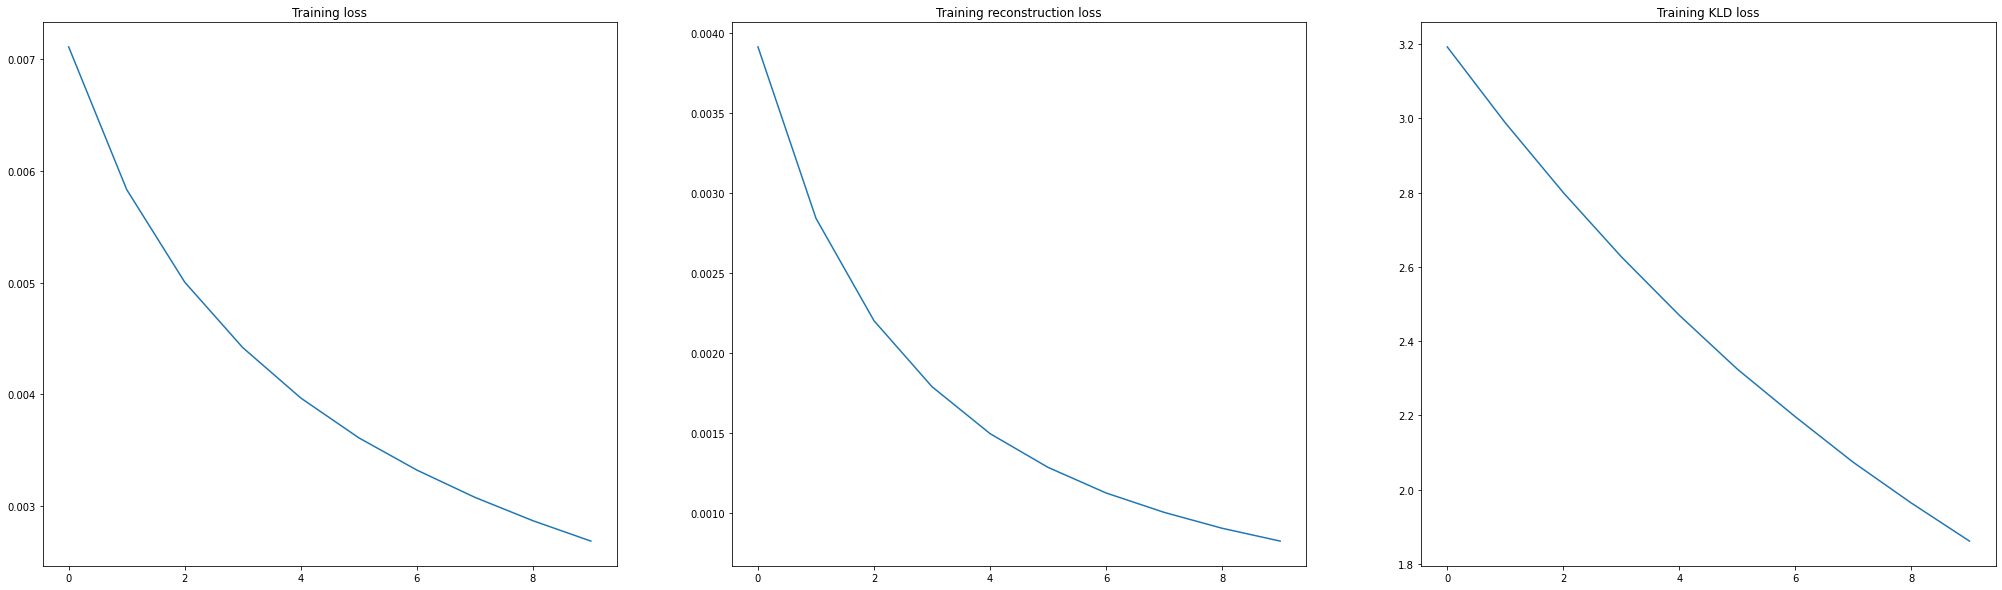

In [31]:
num_list = [i for i in range(epoch_num)]
plt.figure(figsize = (35,10))
plt.subplot(1,3,1)
plt.plot(num_list,running_loss_L2, '-')
plt.title('Training loss')
plt.subplot(1,3,2)
plt.plot(num_list,running_recons_L2, '-')
plt.title('Training reconstruction loss')
plt.subplot(1,3,3)
plt.plot(num_list,running_KLD_L2, '-')
plt.title('Training KLD loss')

In [32]:
val_loss_L2 = [item.detach().cpu().numpy() for item in val_loss_L]
val_loss_L2 = np.array(val_loss_L2)
val_recons_L2 = [item.detach().cpu().numpy() for item in val_recons_L]
val_recons_L2 = np.array(val_recons_L2)
val_KLD_L2 = [item.detach().cpu().numpy() for item in val_KLD_L]
val_KLD_L2 = -np.array(val_KLD_L2)

Text(0.5, 1.0, 'Validation KLD loss')

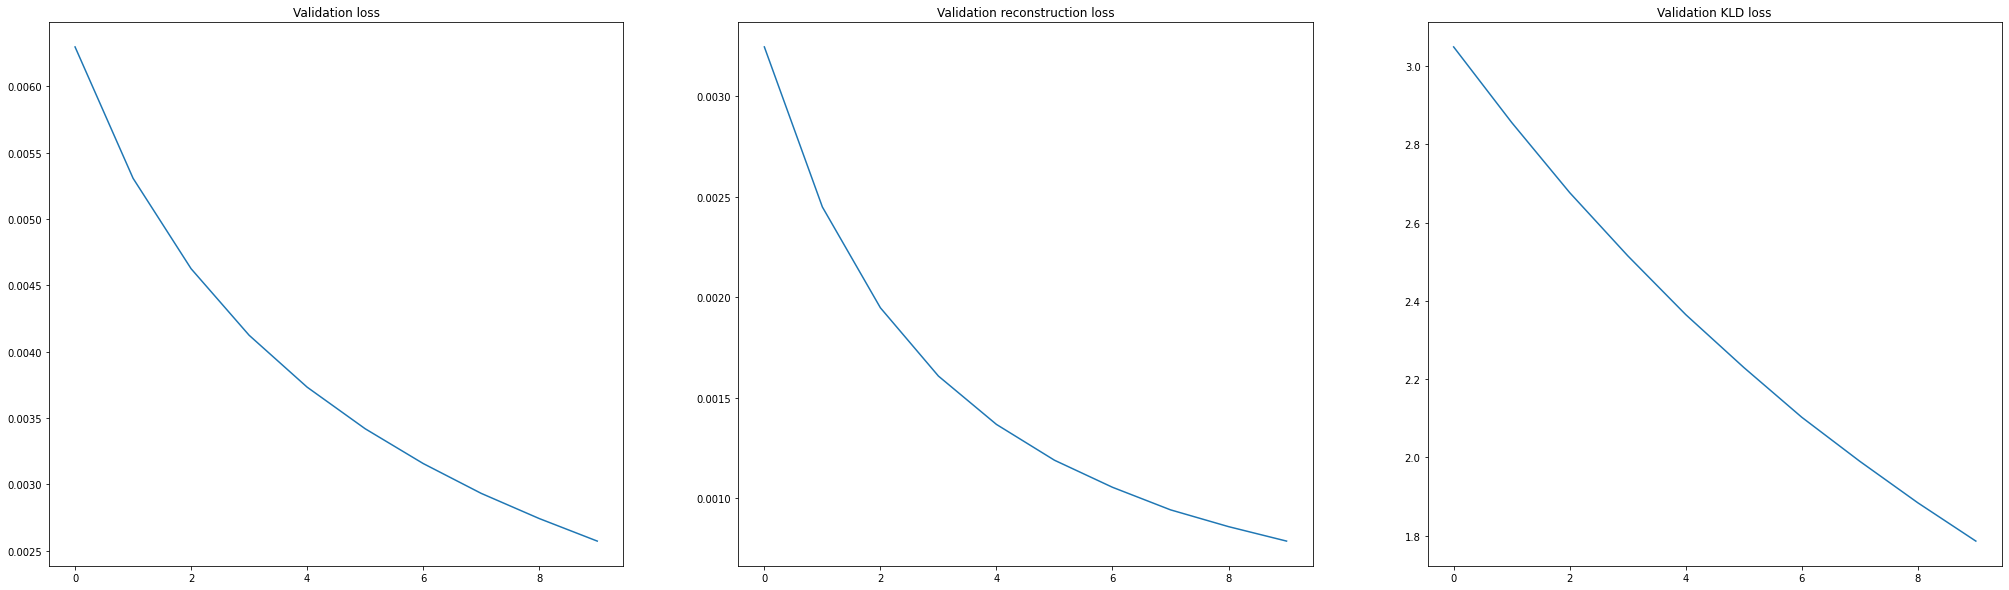

In [33]:
num_list = [i for i in range(epoch_num)]
plt.figure(figsize = (35,10))
plt.subplot(1,3,1)
plt.plot(num_list,val_loss_L2, '-')
plt.title('Validation loss')
plt.subplot(1,3,2)
plt.plot(num_list,val_recons_L2, '-')
plt.title('Validation reconstruction loss')
plt.subplot(1,3,3)
plt.plot(num_list,val_KLD_L2, '-')
plt.title('Validation KLD loss')

In [34]:
input = torch.tensor(signal_list[0:64]).unsqueeze(1).float()
output, input, fg_mu_z, fg_log_var_z = model.forward_fg(input)

Text(0.5, 1.0, 'denoised')

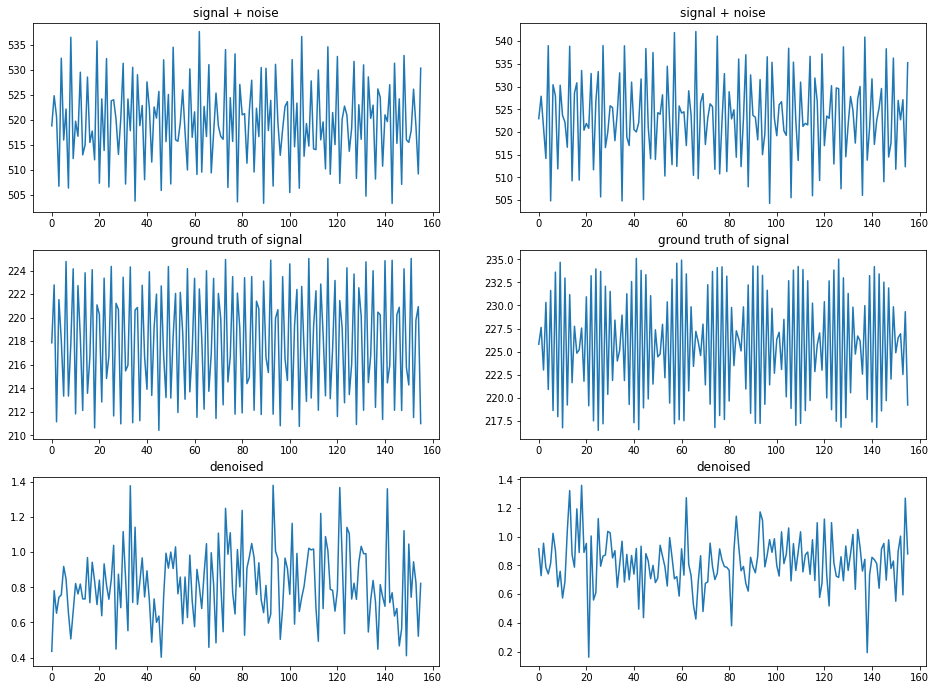

In [35]:
x = [i for i in range(156)]
plt.figure(figsize = (16,16))
plt.subplot(4,2,1)
plt.plot(x,signal_list[25],'-')
plt.title('signal + noise')
plt.subplot(4,2,2)
plt.plot(x,signal_list[19],'-')
plt.title('signal + noise')
plt.subplot(4,2,3)
plt.plot(x,ground_truth[25],'-')
plt.title('ground truth of signal')
plt.subplot(4,2,4)
plt.plot(x,ground_truth[19],'-')
plt.title('ground truth of signal')
plt.subplot(4,2,5)
plt.plot(x,output[25].squeeze().detach().numpy(),'-')
plt.title('denoised')
plt.subplot(4,2,6)
plt.plot(x,output[19].squeeze().detach().numpy(),'-')
plt.title('denoised')

In [36]:
dataloader_iter_gm2 = iter(test_gm)
dataloader_iter_gt = iter(test_gt)
loss = 0

for i in range(len(test_gm)):
  try:
    inputs_gm2 = next(dataloader_iter_gm2)
    ground_truth_gm = next(dataloader_iter_gt)
  except StopIteration:
    dataloader_iter_gm2 = iter(test_gm)
    inputs_gm2 = next(dataloader_iter_gm)

  try:
    inputs_gt = next(dataloader_iter_gt)
    ground_truth_gt = next(dataloader_iter_gt)
  except StopIteration:
    dataloader_iter_gt = iter(test_gt)
    inputs_gt = next(dataloader_iter_gt)
  inputs_gm2 = inputs_gm2.unsqueeze(1).float() /max_signal
  inputs_gm2 = inputs_gm2.to(device)
  output2, inputs_gm2, fg_mu_z, fg_log_var_z = model.forward_fg(inputs_gm2)
  inputs_gt = inputs_gt.unsqueeze(1).float() /max_signal
  inputs_gt = inputs_gt.to(device)

  loss += F.mse_loss(inputs_gm2, output2)

print(loss / testing_gt.shape[0])

tensor(0.0008, grad_fn=<DivBackward0>)
